In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch as th
from datasets import loader
from configs import default_mnist_configs
from utils import dist_util
from sampling.sampling_utils import get_models_from_config,get_models_functions

In [3]:
config = default_test_configs.get_default_configs()
dist_util.setup_dist()
print(f"device {dist_util.dev()}")
print(f"experiment folder {config.experiment_name}")
print(f"Counterfactual target class {config.sampling.counterfactual_class }")

In [6]:
test_loader = loader.get_data_loader(config.data.path, config.sampling.batch_size, split_set='test',
                                         which_label=config.classifier.label)

In [7]:
classifier, diffusion, model = get_models_from_config(config)
cond_fn, model_fn = get_models_functions(config, model, classifier)

EncoderUNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 32, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=128, out_features=64, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 32, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0, inplace=False)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(

In [8]:
data_dict = next(test_loader)

/remote/rds/groups/idcom_imaging/data/MNIST


In [9]:
results_per_sample = {"original": ((data_dict['image'] + 1) * 127.5).clamp(0, 255).to(
    th.uint8)}
# send data points to GPU
model_kwargs = {k: v.to(dist_util.dev()) for k, v in data_dict.items()}
init_image = data_dict['image'].to(dist_util.dev())
# create counterfactual target 
model_kwargs["y"] = (config.sampling.counterfactual_class * th.ones((config.sampling.batch_size,))).to(th.long).to(dist_util.dev())

counterfactual = diffusion.diffscm_counterfactual_sample(
                model_fn
                (config.sampling.batch_size,
                    config.score_model.num_input_channels,
                    config.score_model.image_size,
                    config.score_model.image_size),
                factual_image = init_image,
                anticausal_classifier_fn = cond_fn,
                model_kwargs=model_kwargs,
                device=dist_util.dev(),
                )

counterfactual = ((counterfactual + 1) * 127.5).clamp(0, 255).to(th.uint8)
results_per_sample["counterfactual"] = counterfactual.cpu().numpy()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [38]:
sample_list = np.stack([v[:,0] for (k,v) in results_per_sample.items()])
sample_list = np.einsum("ibwh -> bihw",sample_list)
sample_list = sample_list[:16]
grid = np.concatenate(np.concatenate(sample_list,axis = 2),axis = 0)

((56, 448), (16, 2, 28, 28))

(-0.5, 447.5, 55.5, -0.5)

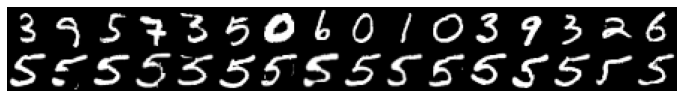

In [39]:
fig = plt.figure(figsize=(12.,40.))
plt.imshow(grid,cmap = 'gray')
plt.axis("off")